#Modelos Generativos: Variational AutoEncoders

Los VAEs son modelos generativos sencillos que intentan maximizar la similitud entre las imágenes generadas y las imágenes con las que han sido alimentadas. Al aprender a representar los valores de entrada en una forma diferente, pero mucho más compacta, se puede hacer un muestreo en la distribución aprendida para poder ser capaz de generar muestras de datos nuevas.

###Reducción de la Dimensionalidad

En el aprendizaje automático, la reducción de dimensionalidad es el **proceso de reducir la cantidad de características que describen algunos datos**. Esta reducción puede llevarse a cabo mediante **`selección`** (solo se conservan algunas características existentes) o mediante **`extracción`** (se crea un número reducido de características nuevas basadas en las características viejas) y puede ser útil en muchas situaciones que requieren datos de baja dimensión (visualización de datos, almacenamiento, cómputos pesados, etc.). Aunque existen muchos métodos diferentes de reducción de dimensionalidad, se puede establecer un marco general que está presente en la mayoría de estos métodos (¡si no es que en todos!).

Primero, llamemos **`encoder`** al proceso que produce la representación de las "características nuevas" a partir de la representación de "características viejas" (mediante selección o extracción) y **`decoder`** al proceso inverso. La reducción de la dimensionalidad se puede interpretar como una compresión de datos donde el encoder comprime los datos (desde el espacio inicial hasta el espacio codificado, también llamado **`espacio latente`**), mientras que el decoder los descomprime. Por supuesto, dependiendo de la distribución de datos inicial, la dimensión del espacio latente y la definición del codificador, esta compresión puede ser **`con pérdida `**, lo que significa que una parte de la información se pierde durante el proceso de codificación y no se puede recuperar al decodificar.

![](https://imagizer.imageshack.com/img923/6084/ejVXLd.png)

El propósito principal de un método de reducción de dimensionalidad es encontrar el mejor par encoder / decoder. En otras palabras, para un conjunto dado de posibles encoders y decoders, estamos buscando el par que **mantiene la máxima información al codificar** y, por lo tanto, **tiene el mínimo error de reconstrucción al decodificar**. Si denotamos respectivamente E y D las familias de encoders y decoders que estamos considerando, entonces se puede escribir el problema de reducción de dimensionalidad como

$(e^*,d^*) = \underset{e, d \in E \times D}{\arg\max}  \epsilon (x, d(e(x)))$

dónde $\epsilon (x, d(e(x)))$ define la medida del error de reconstrucción entre los datos de entrada $x$ y los datos codificados-decodificados $d(e(x))$.

###AutoEncoders

Analicemos ahora los **`AutoEncoders`** y veamos cómo podemos usar las redes neuronales para reducir la dimensionalidad. La idea general de los AutoEncoders es bastante simple y consiste en establecer un Encoder y un Decoder como redes neuronales y aprender el mejor esquema de codificación-decodificación mediante un proceso de optimización iterativo. Entonces, en cada iteración alimentamos la **`Arquitectura del AutoEncoder`** (el encoder seguido del decoder) con algunos datos, comparamos la salida  con los datos iniciales (**función de pérdida**) y propagamos el error a través de la arquitectura para actualizar los pesos de las redes (**backpropagation**).

Por lo tanto, intuitivamente, la Arquitectura del AutoEncoder crea un cuello de botella para los datos que garantiza que solo la parte más importante de la información pueda pasar y reconstruirse. Teniendo en cuenta el marco general, la familia E de los encoders considerados está definida por la arquitectura de red del encoder, la familia D de los decoders considerados está definida por la arquitectura de la red del decoder y la búsqueda del encoder/decoder que minimiza el error de reconstrucción se realiza por descenso de gradiente sobre los parámetros de estas redes.

![AutoEncoder](https://imagizer.imageshack.com/img921/4192/dkjeJD.png)

#### Implementación en PyTorch

In [ ]:


import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#establece la semilla para que los generadores aleatorios sean consistentes entre corridas
torch.manual_seed(0)

#establece cuántas dimensiones tendrá el espacio latente
codings_size = 30

####Creación del Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

####Creación del Decoder

In [ ]:
####Decoder####
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

####Creación del AutoEncoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### Entrenamiento

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        L = 0.0
        N = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            L += loss.sum()
            N += loss.numel()
        print(f'epoch {epoch + 1}, loss {(L/N):f}')

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims)

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

train(autoencoder.to(device), data)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


epoch 1, loss 5618.133789
epoch 2, loss 4783.156738
epoch 3, loss 4619.089355
epoch 4, loss 4509.549316
epoch 5, loss 4424.200195
epoch 6, loss 4357.897461
epoch 7, loss 4302.937012
epoch 8, loss 4256.652832
epoch 9, loss 4218.362305
epoch 10, loss 4182.868164
epoch 11, loss 4156.538086
epoch 12, loss 4128.940918
epoch 13, loss 4108.421875
epoch 14, loss 4086.014648
epoch 15, loss 4069.858154
epoch 16, loss 4049.988281
epoch 17, loss 4035.612305
epoch 18, loss 4018.558350
epoch 19, loss 4004.130859
epoch 20, loss 3990.744873


In [ ]:
#@markdown función show_images
from matplotlib import pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

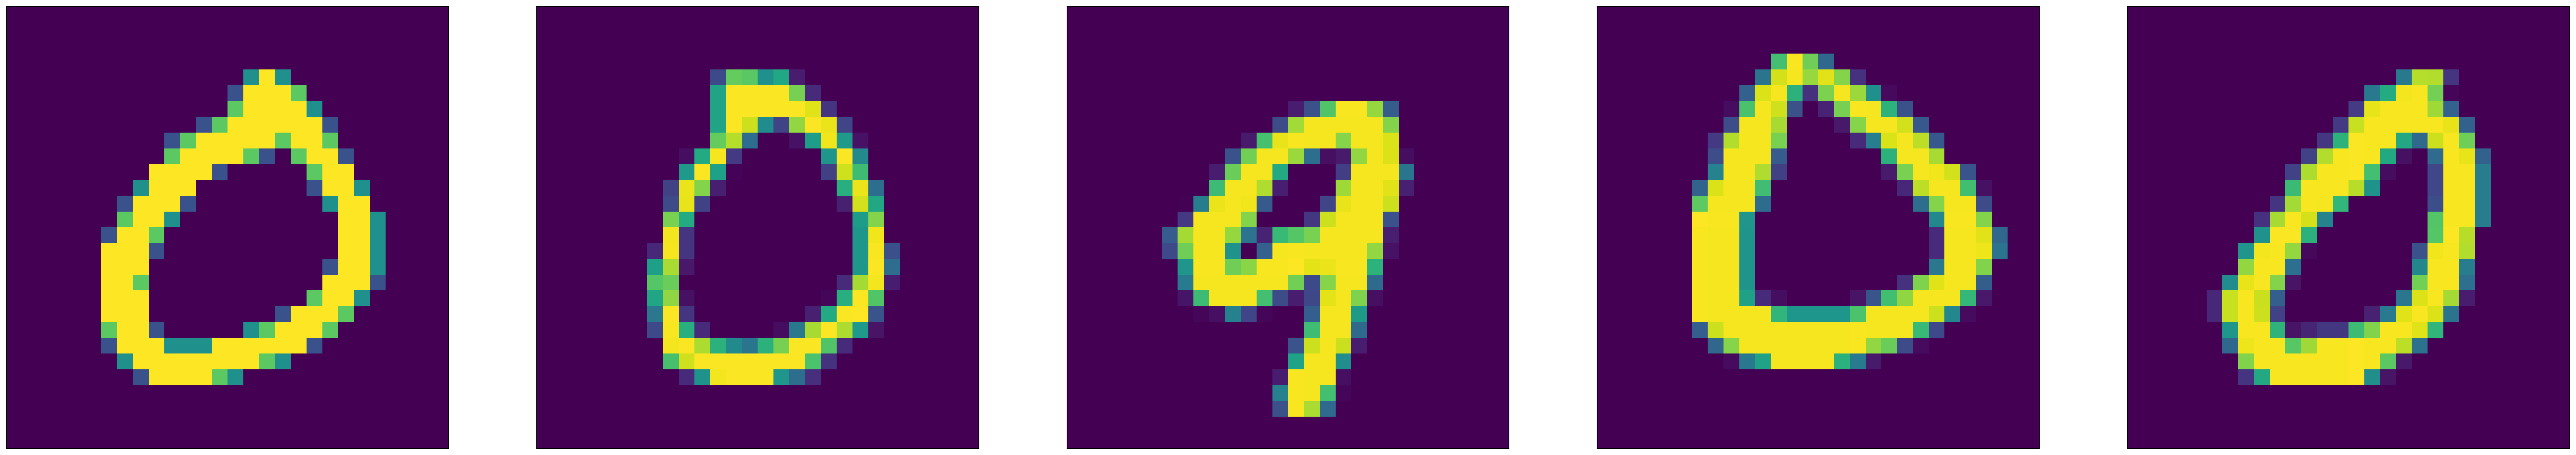

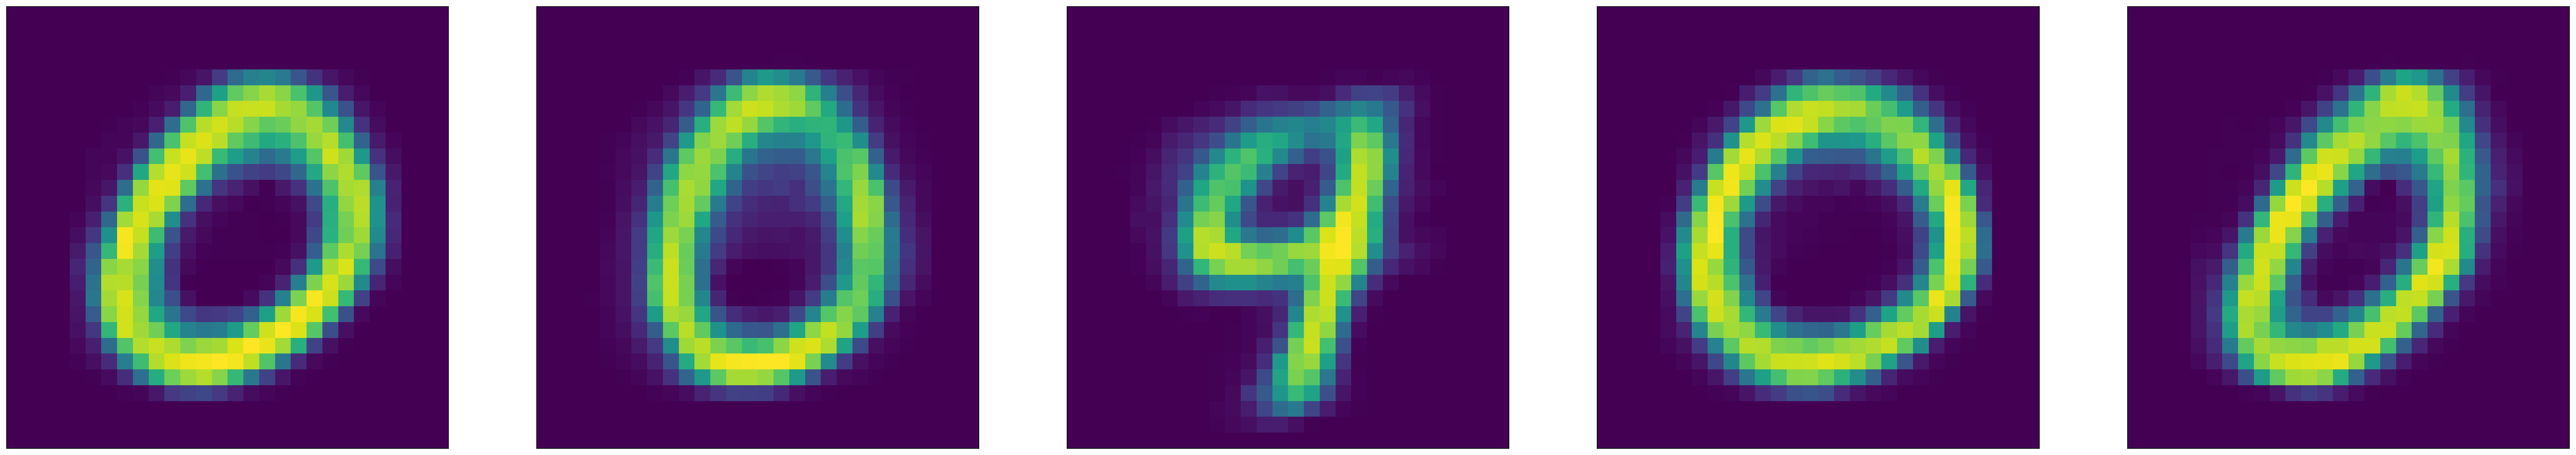

In [ ]:
x, y = next(iter(data))
autoencoder = autoencoder.to(device)
z = autoencoder.encoder(x.to(device))
imgs = 3 * autoencoder.decoder(z)
x,dec_x = x.squeeze(1)[:5], imgs.squeeze(1)[:5]
show_images(x, 1, 5, scale=10);
show_images(dec_x.detach().cpu(), 1, 5, scale=10);

####Utilidad Práctica

Los AutoEncoders tienen tres usos directos en la práctica:


1.   ***`Compresión de Imágenes`***: Dado que un autoencoder puede generar representaciones en espacios de dimensionalidad mucho menor a la imagen original, es un método muy eficiente para comprimir imágenes.
2.   ***`Eliminar el ruido`***: Dado que el decoder aprende a regenerar una imagen de entrada a partir de su representación latente, se puede aplicar un ruido generado automáticamente a una imagen antes de calcular su representación latente y el decoder aprenderá a reconstruir la imagen original sin ruido (ya que la función de pérdida compara la imagen generada con la imagen de entrada que no tiene ruido)![](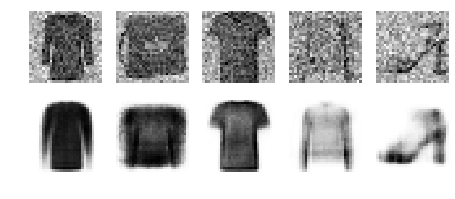%0A)
3. ***`Reconstrucción de sectores de imágenes`***: Dado que existen capas llamadas Dropout que desactivan neuronas aleatorias de la red, se puede generar un efecto de "pérdida de píxeles" en las imágenes que el decoder va a saber recuperar debido a que la función de pérdida tiene en cuenta la imagen completa original.

![](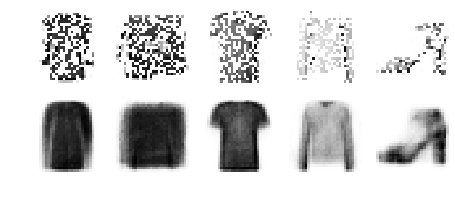%0A)




### Visualización

In [ ]:
def plot_latent(autoencoder, data, num_batches=100, rectangle = None):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    if rectangle is not None:
        rect = plt.Rectangle((rectangle[0],rectangle[1]), rectangle[2], rectangle[3],facecolor='none',ec="red")
        plt.gca().add_patch(rect)

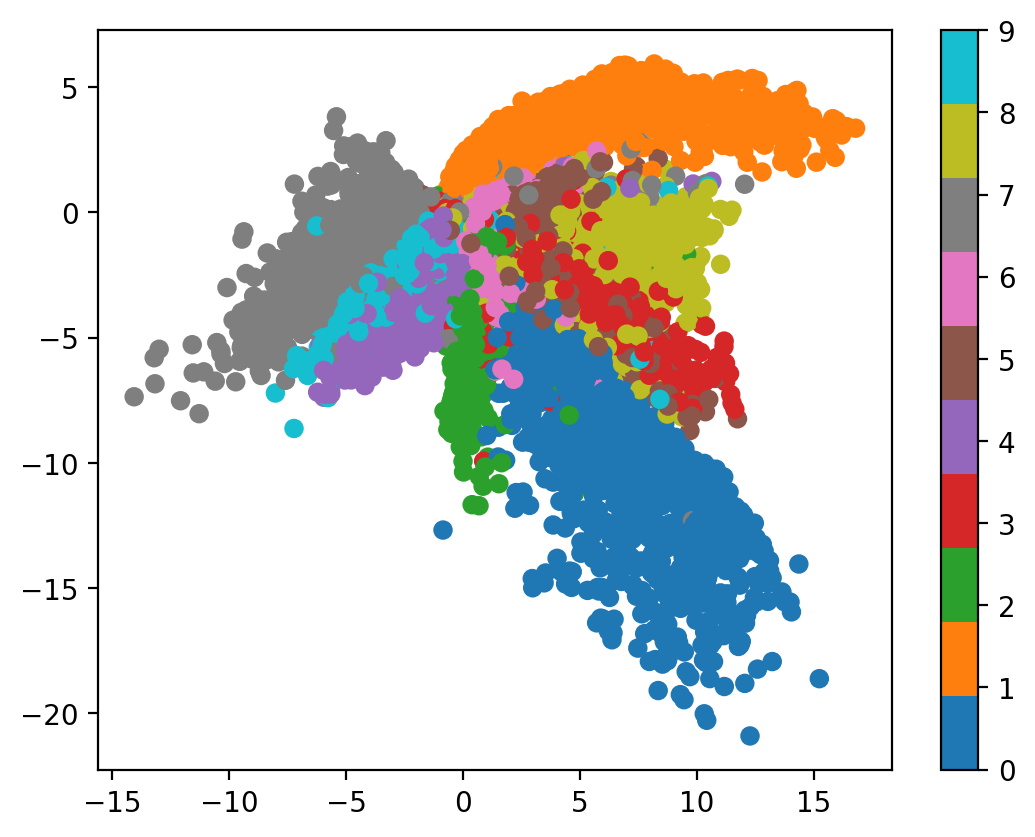

In [ ]:
plot_latent(autoencoder, data)

### Generación de datos nuevos

En este punto, una pregunta natural que viene a la mente es "¿cuál es el vínculo entre los Autoencoders y la generación de contenido?". De hecho, una vez que el Autoencoder ha sido entrenado, tenemos un Encoder y un Decoder, pero aún no hay una forma real de producir ningún contenido nuevo. A primera vista, podríamos sentir la tentación de pensar que, si el espacio latente es lo suficientemente regular (bien "organizado" por el Encoder durante el proceso de entrenamiento), podríamos **`tomar un punto al azar de ese espacio latente y decodificarlo para obtener un nuevo contenido`**.

![Generación de Contenido](https://imagizer.imageshack.com/img924/7237/yYWOSr.png)

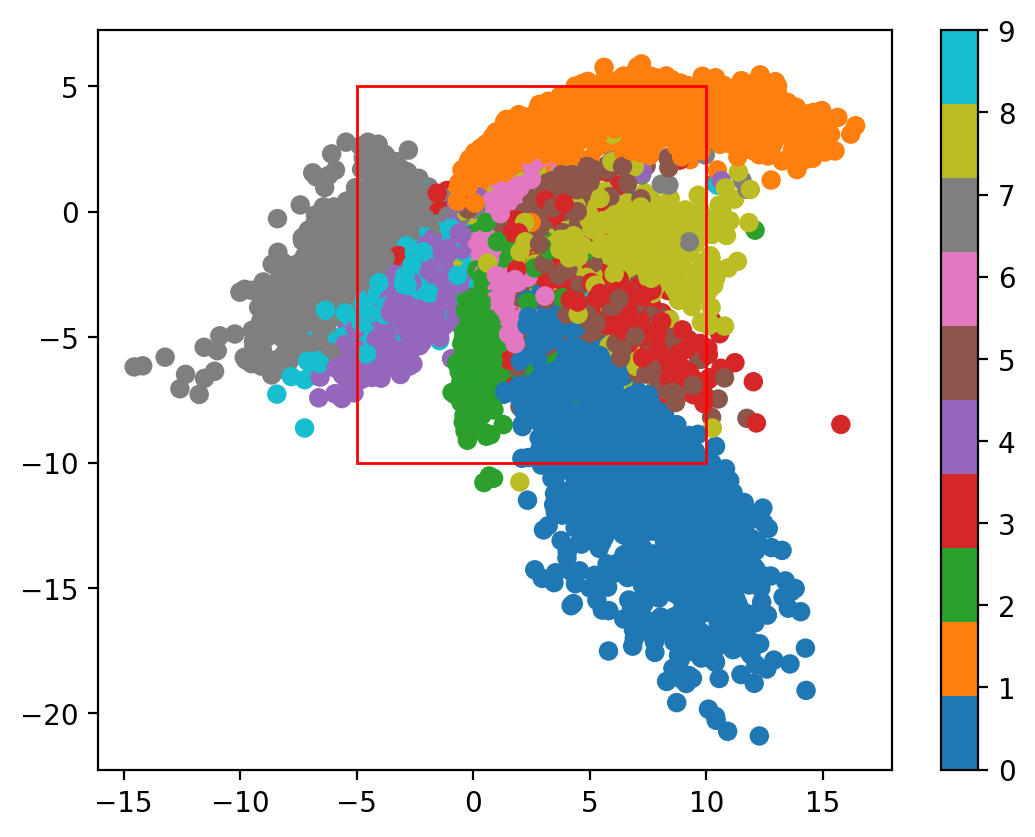

In [ ]:
plot_latent(autoencoder, data, rectangle=(-5,5,15,-15))

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = 2*autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

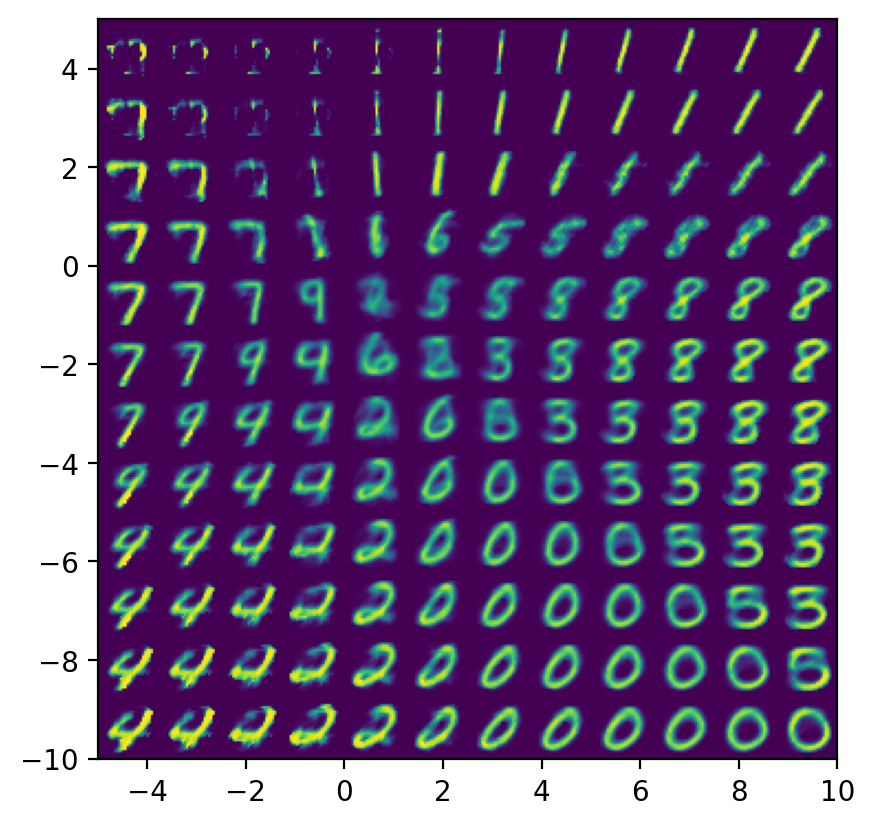

In [ ]:
plot_reconstructed(autoencoder)


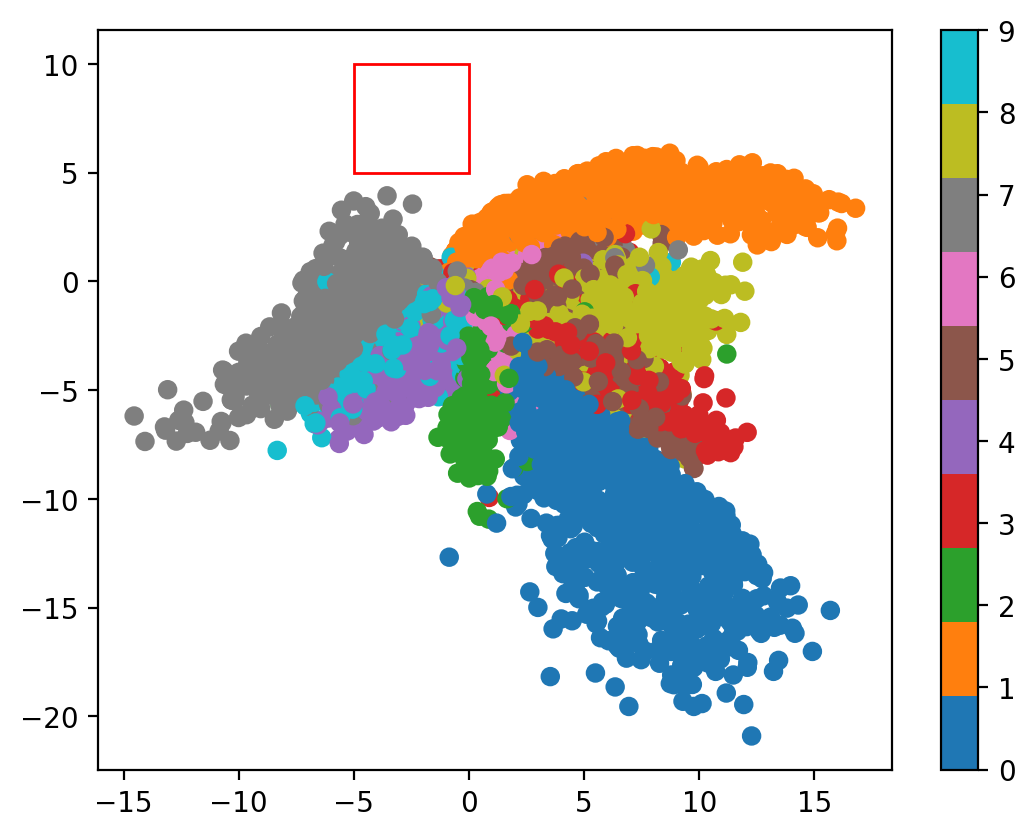

In [ ]:
plot_latent(autoencoder, data, rectangle=(-5,5,5,5))

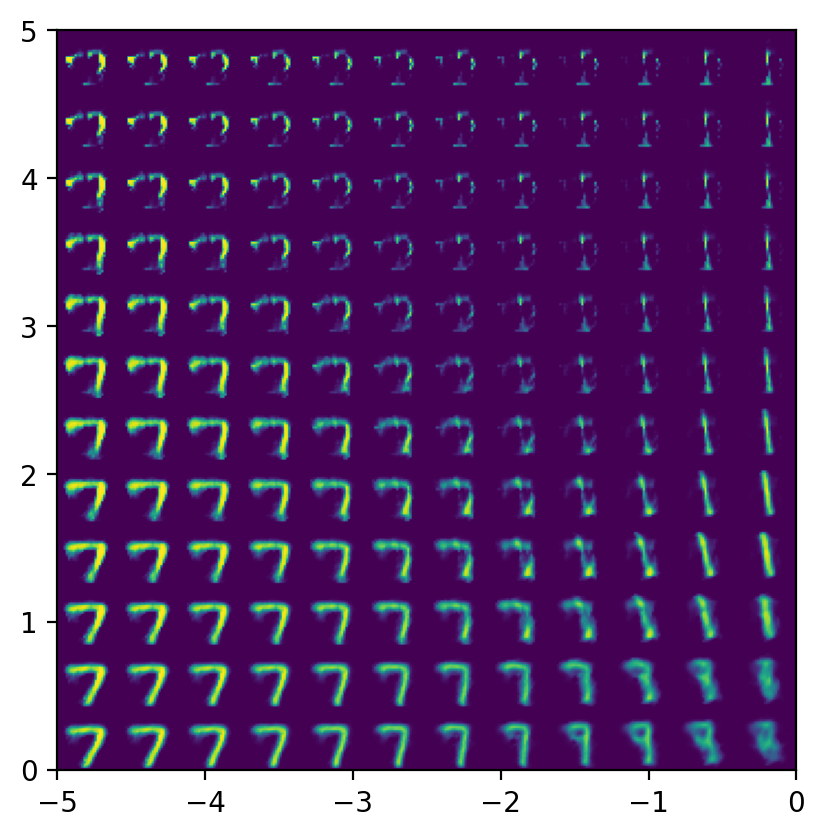

In [ ]:
plot_reconstructed(autoencoder, r0=(-5, 0), r1=(0, 5))

Como podemos ver en las imágenes, el espacio latente creado por el autoencoder es demasiado irregular como para generar contenido tomando cualquier punto del espacio.

La regularidad que se espera del espacio latente para hacer posible el proceso generativo se puede expresar a través de dos propiedades principales:
  

1.   ***`continuidad`***: dos puntos cercanos en el espacio latente no deberían dar dos contenidos completamente diferentes una vez decodificados.
2.   ***`completitud`***: para una distribución elegida , un punto muestreado desde el espacio latente debería dar contenido "significativo" una vez decodificado.



![texto alternativo](https://imagizer.imageshack.com/img922/2469/wrKdU1.png)

Cuanto más compleja es la arquitectura, más dimensiones se puede reducir manteniendo bajo el error de reconstrucción. Intuitivamente, si nuestro Encoder y nuestro Decoder tienen suficientes grados de libertad, podemos reducir cualquier dimensionalidad inicial a 1. De hecho, un encoder con "potencia infinita" podría tomar teóricamente nuestras N dimensiones iniciales y reducirlas a 1, 2, 3, ... hasta N dimensiones y el decoder asociado podría realizar la transformación inversa, sin pérdida durante el proceso.

Acá, sin embargo, debemos tener en cuenta dos cosas. Primero, una reducción importante de la dimensionalidad sin pérdida de reconstrucción a menudo tiene un precio: la **falta de estructuras interpretables y explotables en el espacio latente** (falta de **`regularidad`**). En segundo lugar, la mayoría de las veces el propósito final de la reducción de la dimensionalidad no es solo reducir el número de dimensiones de los datos sino también reducir este número de dimensiones mientras se **mantiene la mayor parte de la información de la estructura de datos en las representaciones reducidas**.



Por estas dos razones, la dimensión del espacio latente y la "profundidad" de los autoencoders (que definen el grado y la calidad de la compresión) deben controlarse y ajustarse cuidadosamente según el propósito final de la reducción de la dimensionalidad.

![ConservarEstructura](https://imagizer.imageshack.com/img921/5562/Rhv9NN.png)

Sin embargo, como discutimos en la sección anterior, la regularidad del espacio latente para los autoencoders es un punto difícil que depende de la ***distribución de los datos*** en el espacio inicial, la ***dimensión del espacio latente*** y la ***arquitectura del encoder***. Por lo tanto, es bastante difícil (si no imposible) asegurar, a priori, que el codificador organizará el espacio latente de una manera inteligente compatible con el proceso generativo que acabamos de describir.

Para ilustrar este punto, consideremos el ejemplo que dimos anteriormente en el que describimos un encoder y un decoder lo suficientemente potentes como para poner cualquier conjunto de datos de entrenamiento inicial de N dimensiones en el eje real (cada punto de datos se codifica como un valor real) y decodificarlos sin ningún pérdida de reconstrucción. En tal caso, el alto grado de libertad del autoencoder que permite codificar y decodificar sin pérdida de información (a pesar de la baja dimensionalidad del espacio latente) conduce a un ***`sobreajuste`*** severo que implica que algunos puntos del espacio latente darán contenido sin sentido una vez decodificado. Aunque este ejemplo unidimensional haya sido elegido voluntariamente como extremo, podemos notar que el problema de la regularidad del espacio latente de los autoencoders es mucho más general que eso y merece una atención especial.

![noRegularizacion](https://imagizer.imageshack.com/img923/1208/qFdhIv.png)

Al pensarlo por un minuto, esta falta de regularidad entre los datos codificados en el espacio latente es bastante normal. De hecho, nada en la tarea que el autoencoder está entrenado para hacer lo fuerza a generar tal regularidad: el autoencoder está entrenado únicamente para ***codificar y decodificar con la menor pérdida posible***, sin importar cómo esté organizado el espacio latente. Por lo tanto, si no tenemos cuidado con la definición de la arquitectura, es natural que, durante el entrenamiento, la red aproveche las posibilidades de sobreajuste para lograr su tarea lo mejor que pueda ... ***`¡a menos que la regularicemos explícitamente!`***

###Definición de AutoEncoder Variacional

Entonces, para poder usar el decoder de nuestro autoencoder con fines generativos, debemos asegurarnos de que el espacio latente sea lo suficientemente regular. Una posible solución para obtener dicha regularidad es introducir una ***`regularización explícita`*** durante el proceso de entrenamiento. Por lo tanto, un autoencoder variacional se puede definir como un ***`autoencoder cuyo entrenamiento se regulariza para evitar el sobreajuste y garantizar que el espacio latente tenga buenas propiedades que permitan el proceso generativo`***.

Al igual que un autoencoder común, un autoencoder variacional es una arquitectura compuesta por un encoder y un decoder y que está entrenado para minimizar el error de reconstrucción entre los datos codificados-decodificados y los datos iniciales. Sin embargo, para introducir cierta regularización del espacio latente, procedemos a una ligera modificación del proceso de codificación-decodificación: **en lugar de codificar una entrada como un solo punto, la codificamos como una *`distribución sobre el espacio latente`***


El modelo se entrena entonces de la siguiente manera:


1.   la entrada se codifica como distribución sobre el espacio latente
2.   se toma una muestra de un punto del espacio latente a partir de esa distribución
3.   se decodifica el punto muestreado y se calcular el error de reconstrucción
4.   el error de reconstrucción se retropropaga a través de la red



![texto alternativo](https://imageshack.com/i/pon0q9dxp)

El simple hecho de que los VAE codifiquen las entradas como distribuciones en lugar de puntos no es suficiente para garantizar la continuidad y la completitud. Sin un término de regularización bien definido, el modelo puede aprender, para minimizar su error de reconstrucción, a "ignorar" el hecho de que tienen que devolver distribuciones y se comportan casi como los autoencoders clásicos (lo que lleva a un sobreajuste). Para hacerlo, el encoder puede devolver ***`distribuciones con pequeñas variaciones`*** (que tenderían a ser distribuciones puntuales) o devolver ***`distribuciones con medias muy diferentes`*** (que estarían muy separadas entre sí en el espacio latente). En ambos casos, las distribuciones se usan de manera incorrecta (cancelando el beneficio esperado) y no se satisface la continuidad y / o completitud.

Entonces, para evitar estos efectos, **tenemos que regularizar tanto la matriz de covarianza como la media de las distribuciones devueltas por el encoder**. En la práctica, esta regularización se realiza haciendo cumplir las distribuciones para que estén cerca de una **`distribución normal estándar`** (centrada y reducida). De esta manera, requerimos que las matrices de covarianza estén cerca de la identidad, evitando distribuciones puntuales, y que la media esté cerca de 0, evitando que las distribuciones codificadas estén demasiado separadas entre sí.

![texto alternativo](https://imagizer.imageshack.com/img921/1481/ZVSMrd.png)

Por lo tanto, la función de pérdida que se minimiza al entrenar un VAE se compone de un ***`"término de reconstrucción" `*** (en la capa final), que tiende a hacer que el esquema de codificación-decodificación sea lo más eficaz posible, y un ***`"término de regularización"`*** (en la capa latente), que tiende a regularizar la organización del espacio latente al hacer que las distribuciones devueltas por el codificador se aproximen a una distribución normal estándar. Ese término de regularización se expresa como la ***`divergencia Kulback-Leibler`*** entre la distribución devuelta y una Gaussiana estándar.

La divergencia Kulback-Leibler entre dos distribuciones cualquieras se define como:

$$KL(P||Q)  = \sum_{x \in X} P(x)log(\frac{P(x)}{Q(x)})$$

y para distribuciones continuas como:

$$KL(P||Q)  = \int P(x) \log P(x) dx - \int P(x) \log Q(x) dx $$

Si reemplazamos $P$ y $Q$ con distribuciones gaussianas univariadas, la divergencia de Kullback-Leibler tiene una forma cerrada que puede expresarse directamente en términos de las medias y las matrices de covarianza de las dos distribuciones. Por lo tanto, solo necesitaremos estos dos datos para calcular este término regularizador.

Si $p(x) = N(\mu_1, \sigma_1)$ y $Q(x) = N(\mu_2, \sigma_2)$

$$\begin{align}
KL(P, Q) &= - \int P(x) \log Q(x) dx + \int P(x) \log P(x) dx\\\\
&=\frac{1}{2} \log (2 \pi \sigma_2^2) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2} (1 + \log 2 \pi \sigma_1^2)\\\\
&= \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
\end{align}$$

Con este término de regularización, evitamos que el modelo codifique los datos muy separados en el espacio latente y fomentamos en la mayor medida posible que las distribuciones tiendan a "**superponerse**", satisfaciendo así las condiciones de continuidad e integridad esperadas. Naturalmente, como para cualquier término de regularización, esto tiene el precio de un **error de reconstrucción mayor en los datos de entrenamiento**. Sin embargo, la compensación entre el error de reconstrucción y la divergencia KL se puede ajustar y veremos en la siguiente sección cómo la expresión del equilibrio emerge naturalmente de nuestra derivación formal.

Para concluir esta subsección, podemos observar que la continuidad y la integridad obtenidas con la regularización tienden a crear un "***`gradiente`***" sobre la información codificada en el espacio latente. Por ejemplo, un punto del espacio latente que estaría a medio camino entre los medios de dos distribuciones codificadas que provienen de diferentes datos de entrenamiento debe decodificarse en algo que esté en algún lugar entre medio de los datos que dieron la primera distribución y los datos que dieron la segunda distribución.


![texto alternativo](https://imagizer.imageshack.com/img922/2899/5Z0nCY.png)

##Creación del Variational AutoEncoder

In [ ]:
class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, latent_dims)
        self.linear4 = nn.Linear(256, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        z = F.relu(self.linear2(x))
        media = self.linear3(z)
        log_var = F.relu(self.linear4(z))
        # Calcula la desviación estándar (std) a partir del logaritmo de la varianza.
        std = torch.exp(0.5*log_var)

        eps = torch.randn_like(std)
        latente = eps.mul(std).add_(media)
        return (latente, media, log_var)

In [ ]:
####Decoder####
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Variational_Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z, media, log_var = self.encoder(x)
        return self.decoder(z), media, log_var

####Función de Pérdida personalizada  para la regularización explícita

In [ ]:
import torch.nn.functional as F

def vae_loss(x, x_hat, media, log_var):
  reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
  #1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean)
  latent_loss = -0.5 * torch.sum(1 + log_var - log_var.exp() - media.pow(2))
  return reconstruction_loss + latent_loss


####Entrenamiento

In [ ]:
#@title Descargar Dataset{ run: "auto" }
#@markdown Esta celda descarga los datasets necesarios para el entrenamiento.

#@markdown Se puede elegir entre un dataset de cifras manuscritas o uno de ropa.
clases = "cifras"  #@param ['cifras', 'fashion']

if clases == "cifras":
  dataset = torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True)
  data_list = [dataset.__getitem__(i)[0] for i in range(len(dataset))]
  labels_list = [dataset.__getitem__(i)[1] for i in range(len(dataset))]
  dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True)
if clases == "fashion":
  dataset = torchvision.datasets.FashionMNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True)
  data_list = [dataset.__getitem__(i)[0] for i in range(len(dataset))]
  labels_list = [dataset.__getitem__(i)[1] for i in range(len(dataset))]
  dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=True)

#####Entrenar el modelo

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        L = 0.0
        N = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, media, std = autoencoder(x)
            l = vae_loss(x,x_hat, media, std)
            l.backward()
            opt.step()
            L += l.sum()
            N += l.numel()
        print(f'epoch {epoch + 1}, loss {(L/N):f}')


latent_dims = 100
vae = Variational_Autoencoder(latent_dims).to(device) # GPU

train(vae, dataloader)

epoch 1, loss 22698.039062
epoch 2, loss 18726.298828
epoch 3, loss 18058.955078
epoch 4, loss 17734.347656
epoch 5, loss 17537.652344
epoch 6, loss 17397.677734
epoch 7, loss 17311.667969
epoch 8, loss 17232.917969
epoch 9, loss 17138.199219
epoch 10, loss 17093.886719
epoch 11, loss 17055.914062
epoch 12, loss 16999.160156
epoch 13, loss 16975.156250
epoch 14, loss 16940.539062
epoch 15, loss 16909.908203
epoch 16, loss 16885.576172
epoch 17, loss 16857.421875
epoch 18, loss 16833.089844
epoch 19, loss 16826.707031
epoch 20, loss 16804.716797


###Evaluación del modelo

A continuación utilizaremos el modelo entrenado para verificar los conceptos teóricos explicados anteriormente.

####Reconstrucción de la entrada

Lo primero que vamos a hacer es evaluar el poder de reconstrucción del autoencoder. Es decir, evaluar qué tan fiel es la salida con respecto a la entrada original.

In [ ]:
#@markdown función show_images
from matplotlib import pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

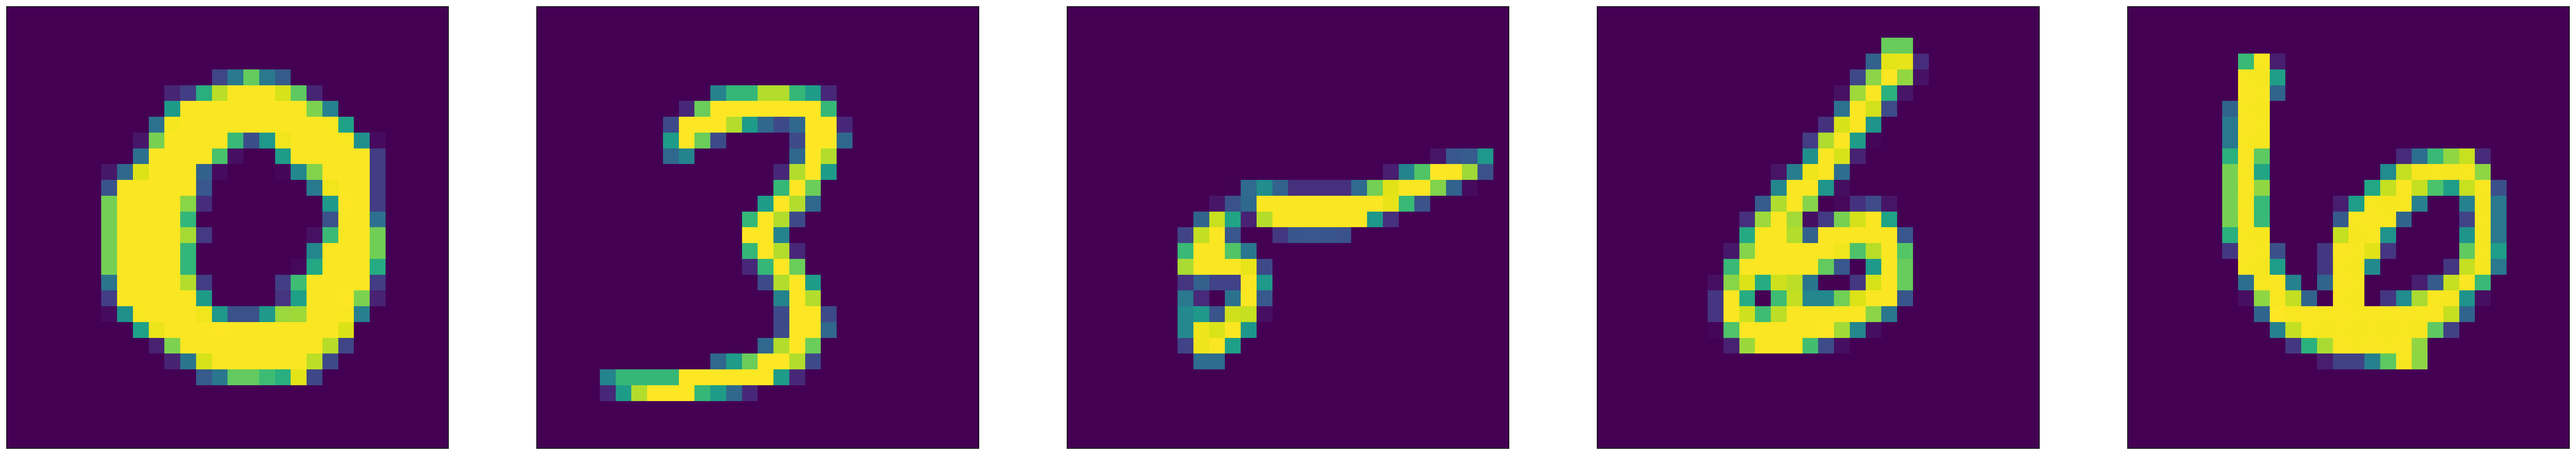

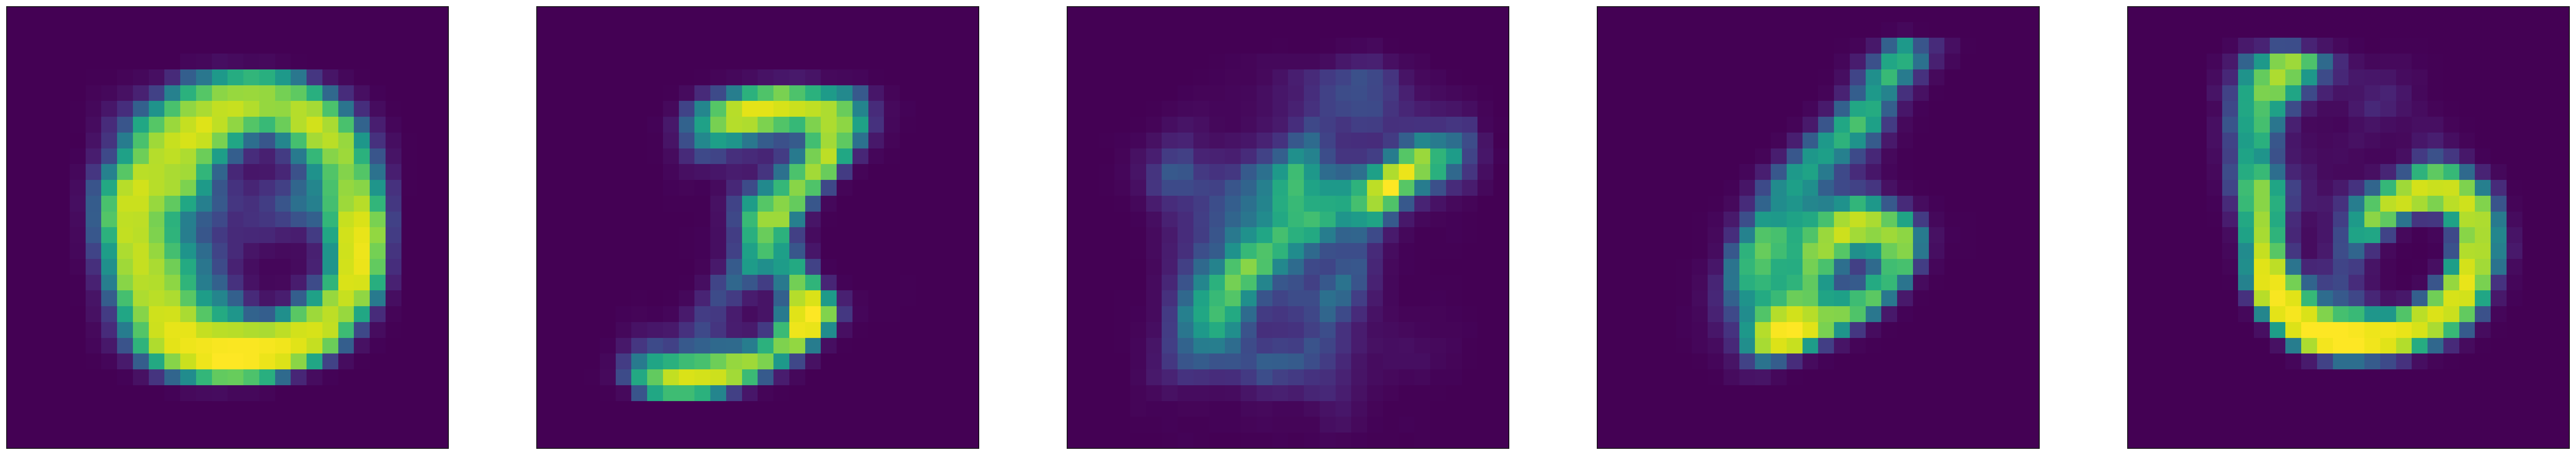

In [ ]:
x, y = next(iter(dataloader))
z,_,_ = vae.encoder(x.to(device))
imgs = 2*vae.decoder(z)
x,dec_x = x.squeeze(1)[:5], imgs.squeeze(1)[:5]
show_images(x, 1, 5, scale=10);
show_images(dec_x.detach().cpu(), 1, 5, scale=10);

####Regularización del espacio latente

Ahora graficaremos el espacio latente para ver si las propiedades deseadas de continuidad y completitud han sido alcanzadas.

Hay que tener en cuenta que sólo podemos graficar el espacio latente si establecimos que la cantidad de dimensiones es 2. Sin embargo reducir tanto la dimensionalidad puede afectar la calidad de las salidas (debido a la alta pérdida de información). Para poder graficar el espacio latente sin perder la calidad del modelo utilizaremos [TSNE](https://tinyurl.com/punrazk) que es un algoritmo que aprende la mejor forma de representar en 2D un espacio de dimensionalidad mayor.

Si bien las gráficas de TSNE a menudo parecen mostrar grupos, los grupos visuales pueden verse fuertemente influenciados por la parametrización elegida y, por lo tanto, es necesaria una buena comprensión del funcionamiento interno del algoritmo antes de arrojar conclusiones a partir de los gráficos obtenidos por este algoritmo. Se puede demostrar que tales "grupos" incluso aparecen en datos no agrupados y por lo tanto pueden ser hallazgos falsos.

<ipython-input-28-b8d57d1814f2>:6: UserWarning: An output with one or more elements was resized since it had shape [10000, 1, 28, 28], which does not match the required output shape [10000, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:30.)
  torch.cat(data_list[0:10000], out=input_data)


torch.Size([10000, 100])


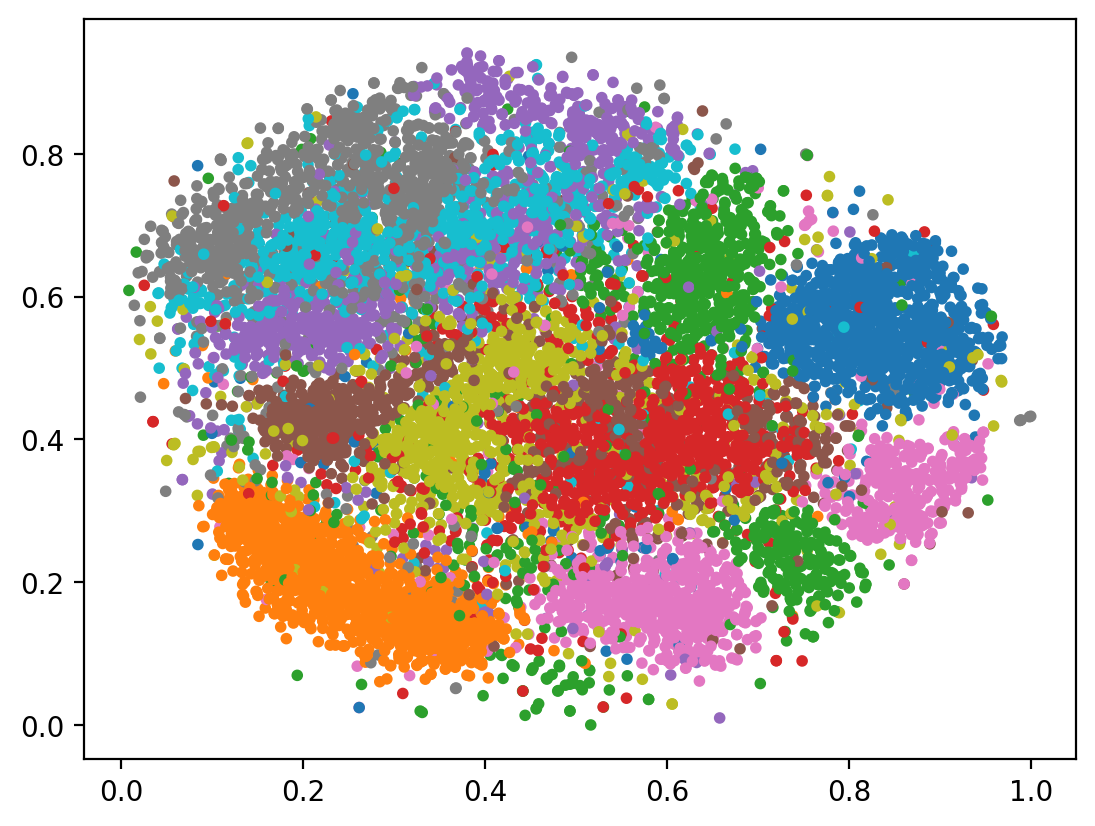

In [ ]:
#importa el algoritmo TSNE
from sklearn.manifold import TSNE

#obtiene la salida del encoder
input_data = torch.Tensor(10000,1,28,28)
torch.cat(data_list[0:10000], out=input_data)
z,_,_= vae.encoder(input_data.to(device))
print(z.shape)

#si el espacio latente tiene 2 dimensiones, directamente grafica la salida del encoder
if z.shape[1]==2:
  z_2D = z
#sino reduce la dimensionalidad hasta 2 y eso es lo que grafica
else:
  tsne = TSNE()
  z_2D = tsne.fit_transform(z.detach().cpu())
  z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())

#muestra el gráfico
plt.scatter(z_2D[:, 0], z_2D[:, 1], c=labels_list[0:10000], s=10, cmap="tab10")
#plt.axis("off")
plt.show()
del input_data


In [ ]:
vae = vae.to(device)

print(torch.cuda.memory_allocated(device))

0


En la imagen podemos ver que los clusteres tienden a superponerse y no dejar huecos entre ellos por lo que podemos declarar que se logró alcanzar la continuidad y la completitud.

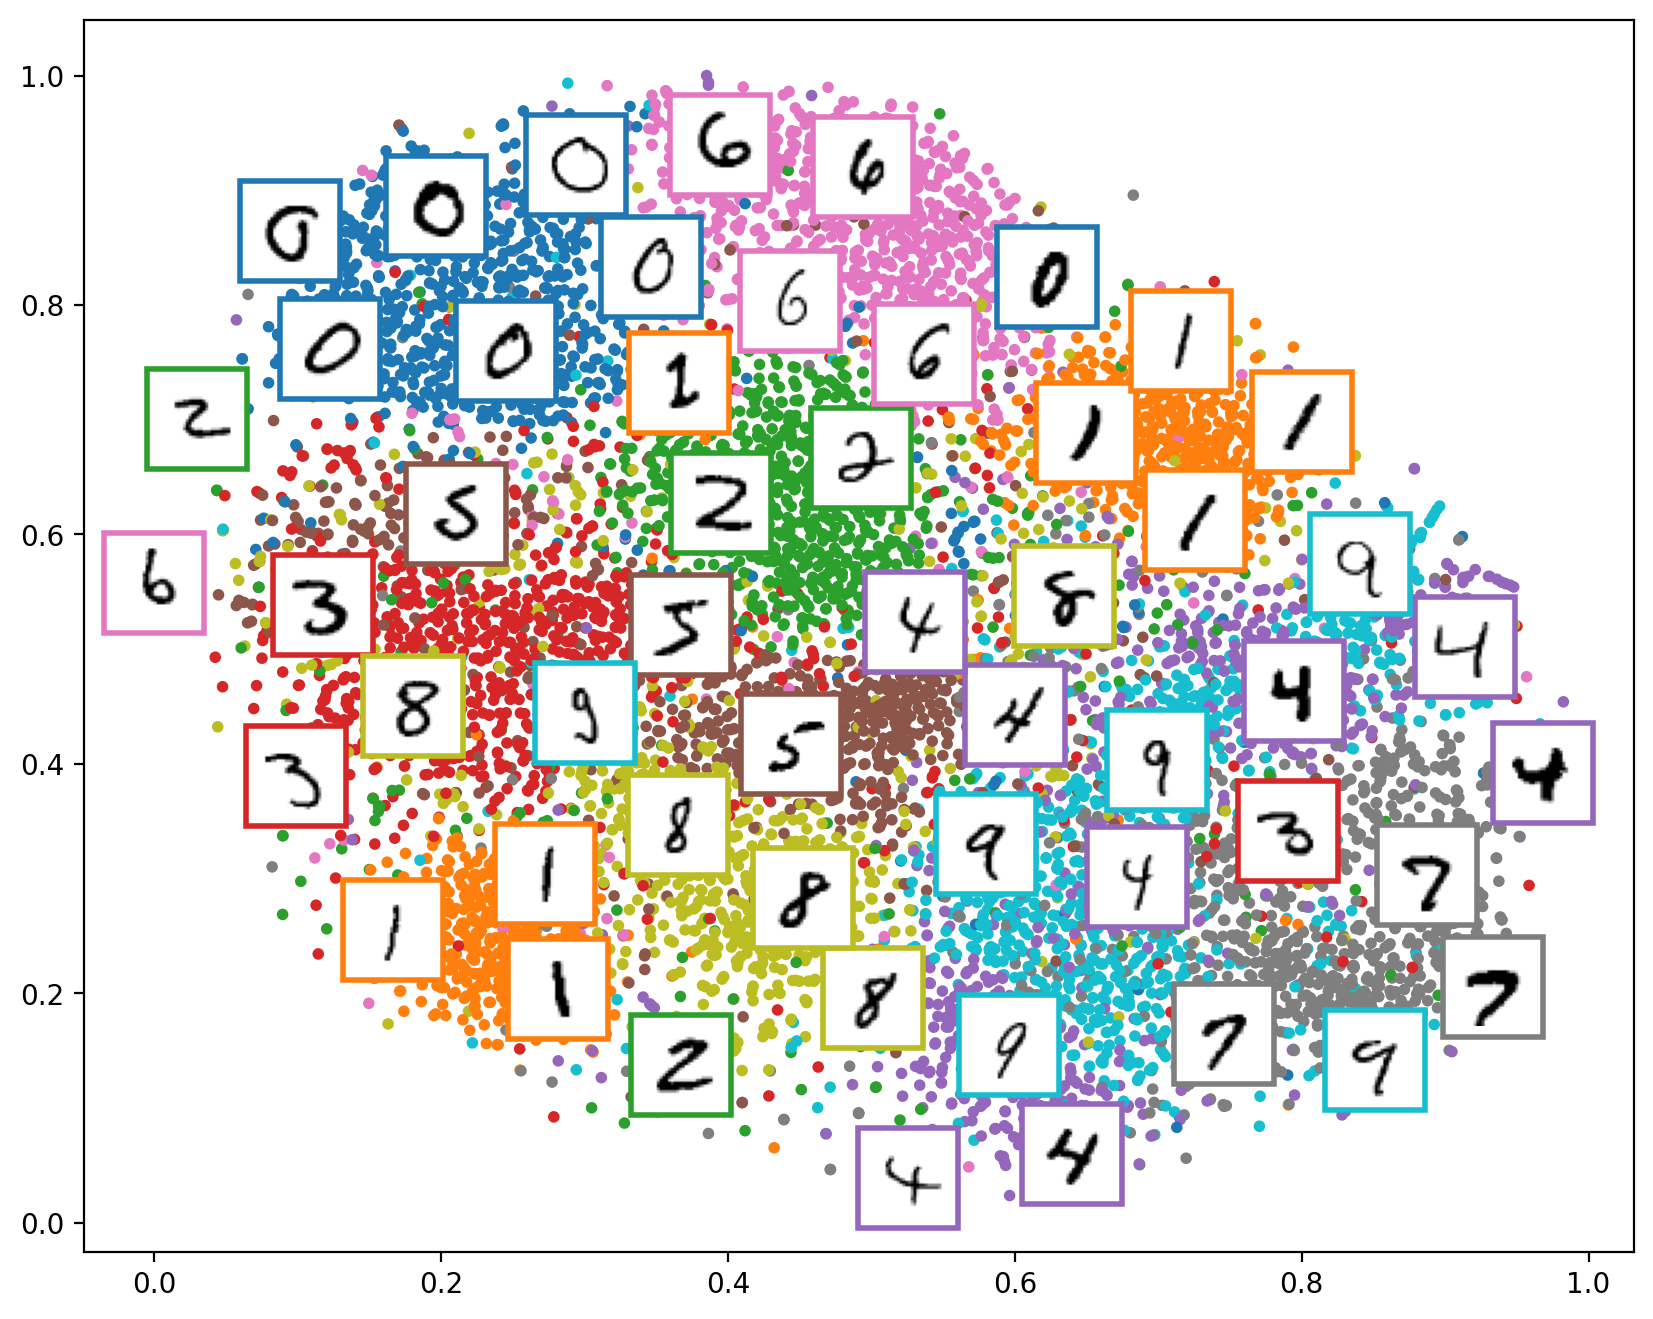

In [ ]:
#@title Graficar Espacio Latente{ run: "auto" }
#@markdown Aumentar el threshold disminuye la cantidad de imágenes mostradas
threshold = 0.01  #@param {type: "slider", min: 0.01, max: 2, step:0.01}
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(z_2D[:, 0], z_2D[:, 1], c=labels_list[0:10000], s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(z_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > threshold: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(data_list[index].squeeze(), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels_list[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
#save_fig("fashion_mnist_visualization_plot")
plt.show()

####Generación de Contenido

##### Dígitos similares a un ejemplo del dataset.

Ahora vamos a ver cómo utilizar nuestro modelo entrenado para generar 10 imágenes decodificadas a partir de muestras latentes.

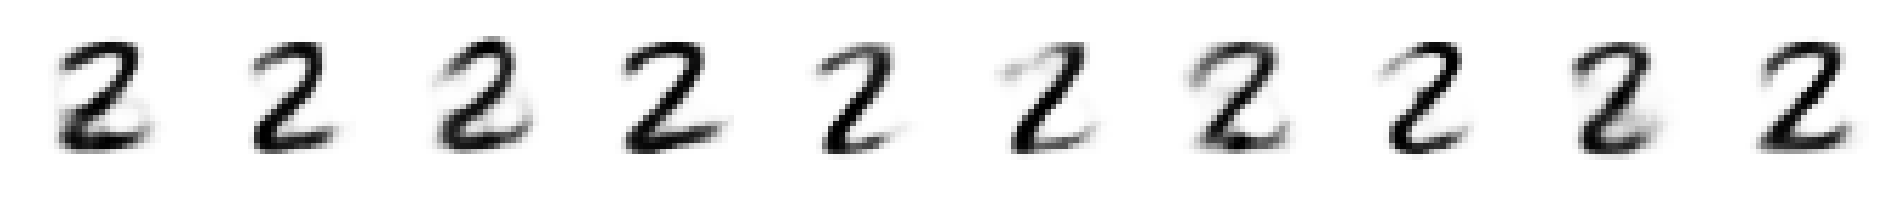

In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# Crear un arreglo de NumPy para almacenar 10 imágenes de tamaño 28x28
random_images = np.zeros((10, 28, 28))

# Seleccionar una imagen aleatoria de data_list y convertirla a tensor de PyTorch
sampled_integer = random.randint(0, 60000)
images_tensor = torch.Tensor(np.array(data_list)[sampled_integer])

# Pasar la imagen a través del encoder del VAE para obtener media y log-varianza
_, mean, log_var = vae.encoder(images_tensor.to(device))

# Generar 10 imágenes aleatorias desde el espacio latente
for i in range(10):
    # Calcular la desviación estándar a partir del logaritmo de la varianza
    std = torch.exp(0.5 * log_var)
    # Generar una perturbación aleatoria con la misma forma que std
    eps = torch.randn_like(std)
    # Calcular el vector latente usando la reparametrización
    latente = eps.mul(std).add_(mean)
    # Decodificar el vector latente para obtener una imagen
    image1 = vae.decoder(latente.to(device))
    # Convertir la imagen a un arreglo de NumPy y almacenarla
    random_images[i] = image1.detach().cpu().numpy()

# Definir una función para mostrar una imagen
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Visualizar las imágenes generadas
fig = plt.figure(figsize=(12, 3))
for image_index in range(random_images.shape[0]):
    plt.subplot(1, 10, 1 + image_index)
    plt.imshow(random_images[image_index].squeeze(), cmap="binary")
    plt.axis("off")





#####Dígito Individual de una clase deseada

Al conocer la distribución de las clases (gracias al encoder) podemos generar un dígito artificial de la clase que nosotros queramos.

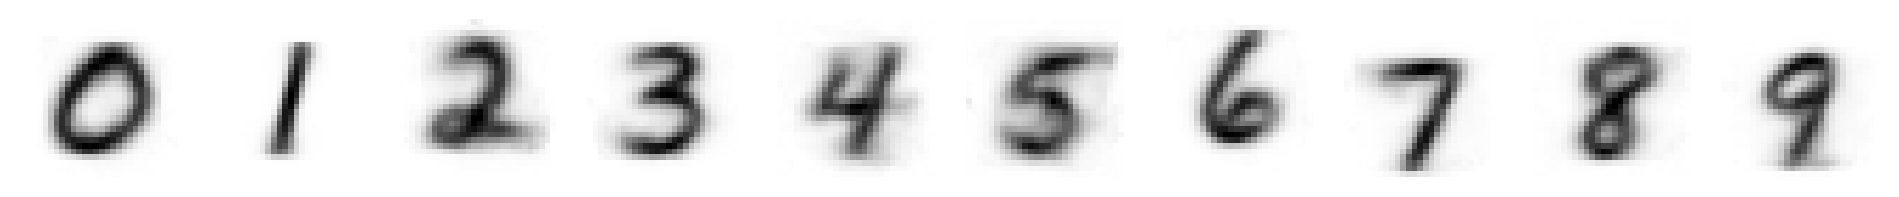

In [ ]:
#genera una imagen promedio para cada cifra
average_images = np.zeros((10,28,28))
for i in range(10):
  #busca las imagenes de un label dado
  indices = np.where(np.array(labels_list) == i)[0].tolist()
  images_tensor = torch.Tensor(np.array(data_list)[indices])
  #torch.cat(images, out=images_tensor).shape
  #comprime las imagenes
  images_compressed,_,_ = vae.encoder(images_tensor.to(device))
  #genera un promedio entre las compresiones
  average = np.sum(images_compressed.detach().cpu().numpy(), axis=0) / images_compressed.shape[0]
  average = np.reshape(average,(1,-1))
  average = torch.from_numpy(average)
  #descomprime la imagen promedio
  average_image = vae.decoder(average.to(device))
  average_images[i]=average_image[0].detach().cpu().numpy()


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
#grafica
fig = plt.figure(figsize=(12, 3))
for image_index in range(average_images.shape[0]):
  plt.subplot(1, 10, 1 + image_index)
  plt.imshow(average_images[image_index].squeeze(), cmap="binary")
  plt.axis("off")

#####Interpolación de imágenes

Al tratar de entender la regularización habíamos llegado a la conclusión de que la continuidad y la completitud causaba un efecto gradiente sobre las imágenes generadas. Es decir, causaba un efecto donde los puntos localizados a igual distancia de las medias de dos gaussianas devolvían imágenes que "mezclaban" ambas clases.


Para observar este efecto gradiente podemos utilizar dos vectores latentes de dos distribuciones distintas, calcular una serie de vectores latentes intermedios y decodificarlos para ver la "mutación".

(100, 17, 1)


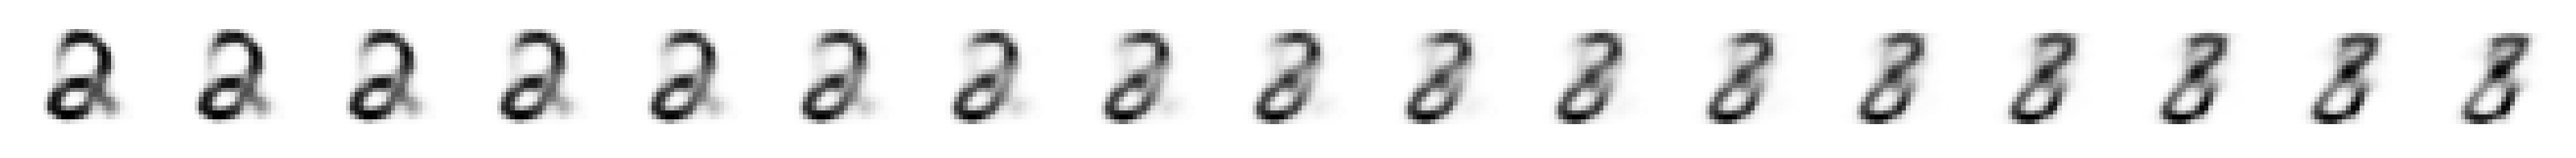

In [ ]:
#Genera n puntos entre v1 y v2
def get_interp(v1, v2, n):
  if not v1.shape == v2.shape:
    raise Exception('Different vector size')

  return np.array([np.linspace(v1[i], v2[i], n+2) for i in range(v1.shape[0])]).T

label1 = 2  #@param {type: "slider", min: 0, max: 9}
label2 = 8  #@param {type: "slider", min: 0, max: 9}

#recupera los indices de las imagenes con el label ingresado
indices1 = np.where(np.array(labels_list) == label1)[0]
indices2 = np.where(np.array(labels_list) == label2)[0]

#elige un indice al azar
index1 = np.random.choice(indices1)
index2 = np.random.choice(indices2)

#codifica las imagenes
img1_compressed,_,_ = vae.encoder(dataset[index1][0].to(device))
img2_compressed,_,_ = vae.encoder(dataset[index2][0].to(device))

#interpola puntos entre ambos extremos
interp = get_interp(img1_compressed.detach().cpu(),
                    img2_compressed.detach().cpu(), 15)
print(interp.shape)
interp = interp[:,:,0].transpose()

#decodifica los puntos latentes interpolados
interp = torch.from_numpy(interp).unsqueeze(0)
artificial_images = vae.decoder(interp.to(device))

#grafica los resultados
n_images = artificial_images.shape[0]
fig = plt.figure(figsize=(n_images * 1.2, 1.5))
for image_index in range(n_images):

  plt.subplot(1, n_images, 1+image_index)
  plt.imshow(artificial_images[image_index].squeeze().detach().cpu(), cmap="binary")
  plt.axis("off")